In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import resnet152
from torch.utils import data
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import sys 
sys.path.append('..')
from dataset import NyuV2
from den import DEN

%matplotlib inline

Evaluate Original ResNet-152

In [2]:
model = resnet152(pretrained=True)

In [2]:
preprocess = transforms.Compose([
                 transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(),
                 transforms.Normalize(
                                 mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [3]:
img = Image.open("./data/imagenet/bee.jpg")
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
model.eval()
out = model(batch_t)

FileNotFoundError: [Errno 2] No such file or directory: './data/imagenet/bee.jpg'

In [5]:
out.argmax() # bee

tensor(309)

Evaluate Resnet (fully trained) for Depth

In [4]:
data_path = '../data/nyu_v2/'
batch_size = 16
depth_size = (25, 32)
seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
test_loader = data.DataLoader(NyuV2(os.path.join(data_path, 'val')),
                              batch_size=batch_size, shuffle=True)

In [8]:
model_file = '../models/024_resnet_model.pt'
model = resnet152(pretrained=False)
model.fc = nn.Linear(2048, depth_size[0] * depth_size[1])
model.load_state_dict(torch.load(model_file))
model = model.to(device)

In [12]:
def evaluate():
    model.eval()
    test_loss = 0
    for batch, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        depth_maps = model(data)
        loss = F.mse_loss(depth_maps, labels, reduction='sum')
        test_loss += loss.item()
    
    return (test_loss / len(test_loader.dataset))**0.5

In [13]:
evaluate()

2.6855404601283372

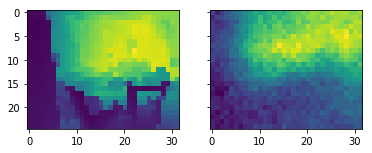

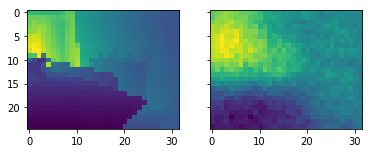

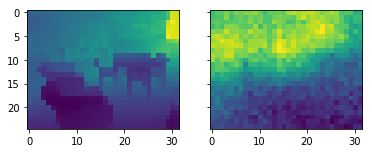

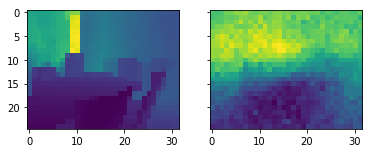

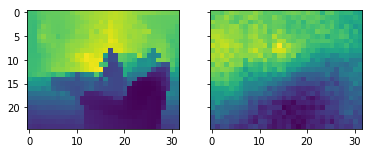

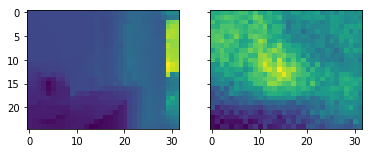

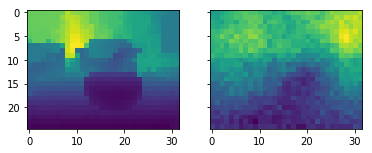

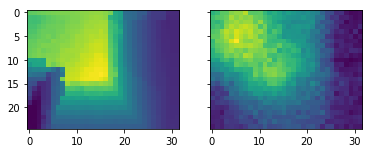

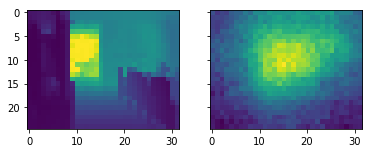

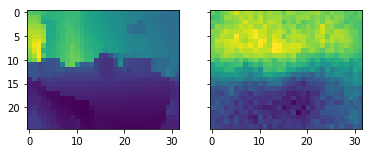

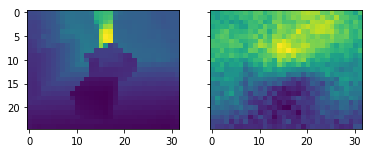

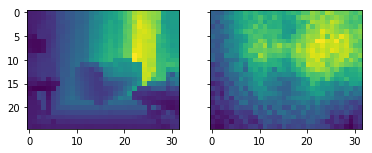

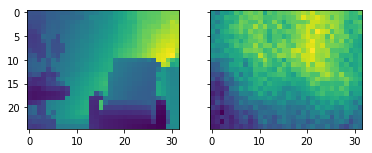

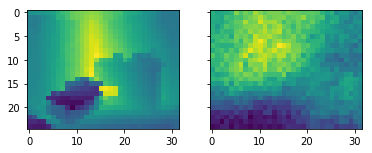

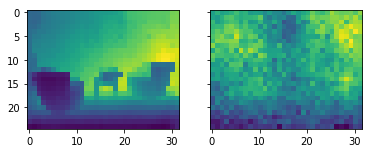

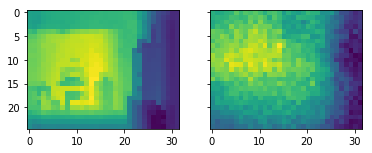

In [11]:
sample = next(iter(test_loader))
d = sample[1]
d_pred = model(sample[0].to(device))

for i in range(batch_size):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(d[i].view(depth_size))
    ax2.imshow(d_pred[i].view(depth_size).cpu().data.numpy())